# Imports

In [8]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import time
from multiprocessing import Pool

In [9]:
data_path = Path('./nexar-collision-prediction')
df_test = pd.read_csv(data_path / 'test.csv')
df_train = pd.read_csv(data_path / 'train.csv')

In [10]:
df_train.head()

,id,time_of_event,time_of_alert,target
0,1924,NaN,NaN,0
1,822,19.5,18.633,1
2,1429,NaN,NaN,0
3,208,19.8,19.233,1
4,1904,NaN,NaN,0


In [13]:
df_train

,id,time_of_event,time_of_alert,target
0,1924,NaN,NaN,0
1,822,19.500,18.633,1
2,1429,NaN,NaN,0
3,208,19.800,19.233,1
4,1904,NaN,NaN,0
...,...,...,...,...
1495,500,19.933,18.633,1
1496,519,19.567,19.033,1
1497,262,17.900,13.933,1
1498,391,19.867,19.267,1


In [3]:
df_test.head()

,id
0,204
1,30
2,146
3,20
4,511


# EDA

In [6]:
df_train['time_of_event'] = df_train['time_of_event'].fillna(0)
df_train['time_of_alert'] = df_train['time_of_alert'].fillna(0)

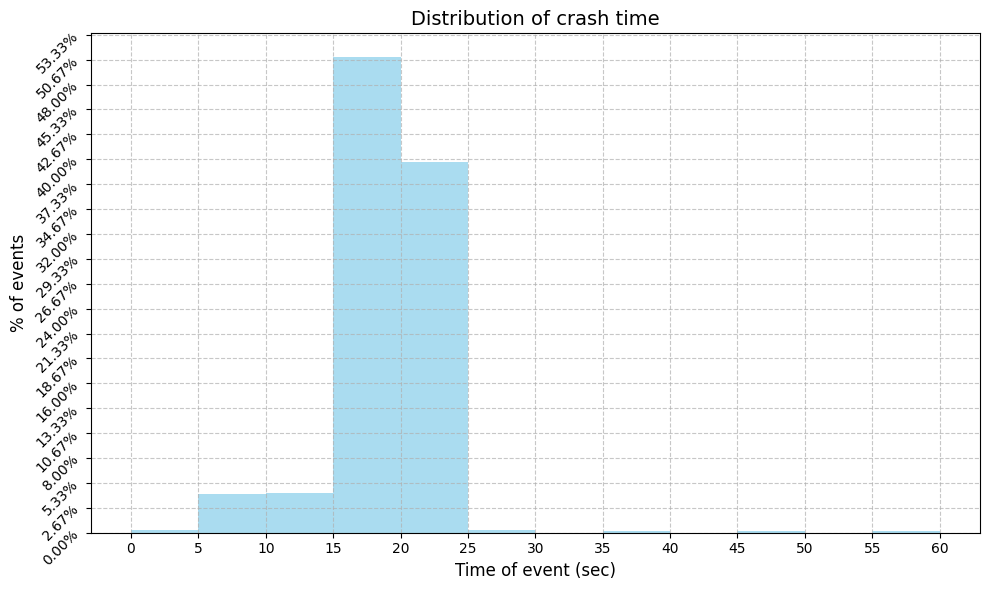

In [209]:
df_crash = df_train[df_train['target'] == 1]

s_time = df_crash.time_of_event
xbins = np.arange(0, 65, 5)
fig, ax = plt.subplots(figsize=(10, 6))

counts, bins, patches = ax.hist(s_time, bins=xbins, alpha=0.7, color='skyblue')

# format the x-axis
ax.set_xticks(ticks=xbins, labels=xbins)

# Format the y-axis
heights = np.array([float(patch.get_height()) for patch in ax.containers[0]])
yticks = np.arange(0, heights.max()+20, 20)
ylabels = list((yticks / heights.sum())*100)
ylabels = list(map(lambda x: f"{x:.2f}%", ylabels))
ax.set_yticks(ticks=yticks, labels=ylabels)
ax.tick_params(axis='y', labelrotation=45)

# Add labels and title
ax.set_xlabel('Time of event (sec)', fontsize=12)
ax.set_ylabel('% of events', fontsize=12)
ax.set_title('Distribution of crash time', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

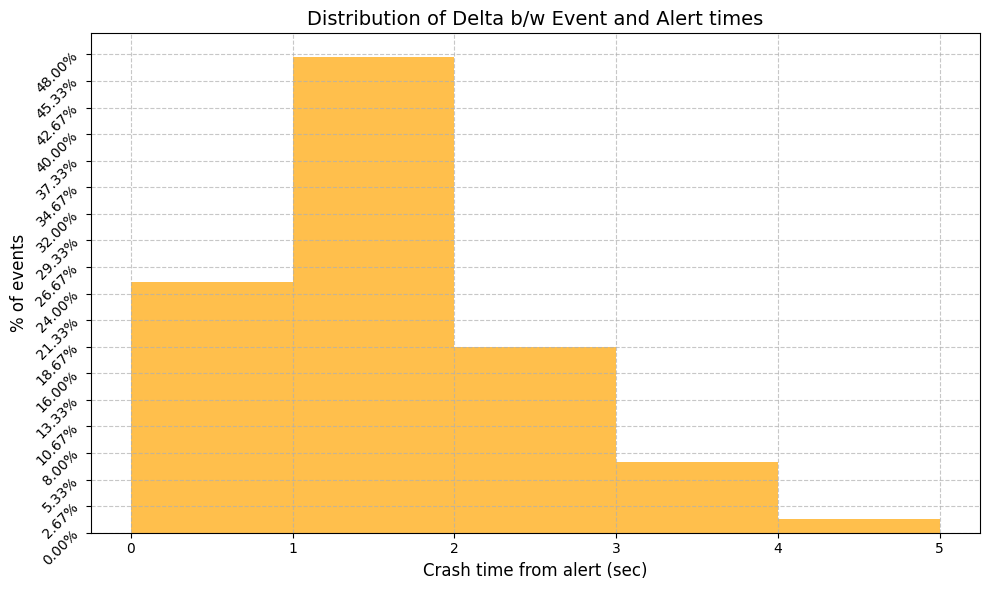

In [230]:
delta_te_ta = df_crash.time_of_event - df_crash.time_of_alert

fig, ax = plt.subplots(figsize=(10, 6))

xbins = np.arange(0, 6, 1)
counts, bins, patches = ax.hist(delta_te_ta, bins=xbins, alpha=0.7, color='orange')

# Format the y-axis
heights = np.array([float(patch.get_height()) for patch in ax.containers[0]])
yticks = np.arange(0, heights.max()+20, 20)
ylabels = list((yticks / heights.sum())*100)
ylabels = list(map(lambda x: f"{x:.2f}%", ylabels))
ax.set_yticks(ticks=yticks, labels=ylabels)
ax.tick_params(axis='y', labelrotation=45)

# Add labels and title
ax.set_xlabel('Crash time from alert (sec)', fontsize=12)
ax.set_ylabel('% of events', fontsize=12)
ax.set_title('Distribution of Delta b/w Event and Alert times', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Torch dataset

In [298]:
from torch.utils.data import Dataset
import torch
class DashcamDataset(Dataset):
        def __init__(self, processed_data, annotations, transform=None):
            self.processed_data = processed_data
            self.annotations = annotations
            self.transform = transform
            self.video_ids = list(processed_data.keys())
            
        def __len__(self):
            return len(self.video_ids)
            
        def __getitem__(self, idx):
            video_id = self.video_ids[idx]
            data = self.processed_data[video_id]
           
            # Get frames and optical flow
            frames = data['frames']
           
           # Apply transformations to frames
            if self.transform:
                frames_tensor = self.transform(frames)
            else:
               # Convert to tensor manually
                frames_tensor = torch.from_numpy(frames.transpose(0, 3, 1, 2)).float() / 255.0
           
           # Load label and alert time
            label = self.annotations[video_id]['label']
            alert_time = self.annotations[video_id].get('alert_time', 0)
           
            return {
               'frames': frames_tensor,
               'label': torch.tensor(label).float(),
               'alert_time': torch.tensor(alert_time).float(),
               'video_id': video_id
            }

## Pre-processing

In [271]:

def extract_keyframes(video_path, num_frames=12, target_size=(160, 160)):
    """
    Extracts key frames from the video, focusing on the final part where collisions typically occur.
    Uses exponential distribution to give more weight to frames closer to the end.
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Could not open the video: {video_path}")
        return np.zeros((num_frames, target_size[0], target_size[1], 3), dtype=np.uint8)
    
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    if total_frames <= 0:
        print(f"Video without frames: {video_path}")
        cap.release()
        return np.zeros((num_frames, target_size[0], target_size[1], 3), dtype=np.uint8)
    
    # Calculate video duration in seconds
    duration = total_frames / fps if fps > 0 else 0
    
    # If the video is short (less than 10 seconds), distribute frames uniformly
    if duration < 10:
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    else:
        # Concentrate 80% of frames in the last 3 seconds (critical area)
        end_frames = int(num_frames * 0.8)
        start_frames = num_frames - end_frames
        
        # Calculate the starting index for the last 3 seconds
        last_seconds = 3
        last_frame_count = min(int(fps * last_seconds), total_frames - 1)
        start_idx = max(0, total_frames - last_frame_count)
        
        # Exponential distribution to give more weight to the last frames
        # This creates indices that are more densely packed toward the end
        end_indices = np.array([
            start_idx + int((total_frames - start_idx - 1) * (i/end_frames)**2) 
            for i in range(1, end_frames + 1)
        ])
        
        # Initial frames distributed uniformly for context
        begin_indices = np.linspace(0, start_idx - 1, start_frames, dtype=int) if start_idx > 0 else np.zeros(start_frames, dtype=int)
        
        # Combine indices
        frame_indices = np.concatenate([begin_indices, end_indices])
    
    # Extract selected frames
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            # Use higher resolution and better interpolation
            frame = cv2.resize(frame, target_size, interpolation=cv2.INTER_LANCZOS4)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        else:
            frames.append(np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8))
    
    cap.release()
    return np.array(frames, dtype=np.uint8)

In [49]:
video_path = data_path / 'train'/ '00000.mp4'

frames = extract_keyframes(video_path)

In [278]:
def process_video(args):
    """
    Function to process an individual video.
    """
    video_path, video_id, num_frames = args
    try:
        # Extract frames with higher resolution
        frames = extract_keyframes(video_path, num_frames=num_frames, target_size=(160, 160))
        
        # Calculate optical flow
        # optical_flow = compute_optical_flow(frames, skip_frames=1)
        
        # We return NumPy arrays instead of applying transformations now
        return video_id, {
            'frames': frames,
            # 'optical_flow': optical_flow,
        }
    except Exception as e:
        print(f"Error processing video {video_id}: {str(e)}")
        return video_id, None

def parallel_preprocess_dataset(video_dir, video_ids, num_frames=8, num_workers=4):
    """
    Pre-processes multiple videos in parallel.
    """
    args_list = []
    for video_id in video_ids:
        video_path = os.path.join(video_dir, f"{video_id}.mp4")
        if os.path.exists(video_path):
            args_list.append((video_path, video_id, num_frames))
    
    start_time = time.time()
    print(f"Starting parallel pre-processing of {len(args_list)} videos with {num_workers} workers...")
    
    processed_data = {}
    with Pool(num_workers) as p:
        results = p.map(process_video, args_list)
        for video_id, data in results:
            if data is not None:
                processed_data[video_id] = data
    
    print(f"Pre-processing completed in {time.time() - start_time:.2f} seconds.")
    print(f"Processed {len(processed_data)} out of {len(args_list)} videos.")
    
    return processed_data

In [284]:

train_video_ids = list(train_annons.keys())
val_video_ids = list(val_annons.keys())

train_dir = data_path/'train'
train_processed = parallel_preprocess_dataset(train_dir, train_video_ids, num_frames=32, num_workers=32)
val_processed = parallel_preprocess_dataset(train_dir, val_video_ids, num_frames=32, num_workers=16)

Starting parallel pre-processing of 1275 videos with 32 workers...
Pre-processing completed in 848.53 seconds.
Processed 1275 out of 1275 videos.
Starting parallel pre-processing of 225 videos with 16 workers...
Pre-processing completed in 144.72 seconds.
Processed 225 out of 225 videos.


In [243]:
def get_annotations(df:pd.DataFrame) -> dict:
    annotations = {}
    for _, row in df.iterrows():
        video_id = f"{int(row['id'].item()):05d}"
        annotations[video_id] = {
            'label': int(row['target'].item()),
            'alert_time': row['time_of_alert'].item(),
            'event_time': row['time_of_event'].item()
        }
    return annotations

In [259]:
val_idx = df_train.sample(frac=0.15, random_state=42).index

df_train_rand = df_train.loc[~df_train.index.isin(val_idx)]
df_val_rand = df_train.loc[df_train.index.isin(val_idx)]

train_annons = get_annotations(df_train_rand)
val_annons = get_annotations(df_val_rand)

In [292]:
train_dataset = DashcamDataset(train_processed, train_annons)
val_dataset = DashcamDataset(val_processed, val_annons)vision.dat

# Model

In [301]:
from torchvision.models import vit_b_16

model = vit_b_16()

In [ ]:
from torch.utils.data import DataLoader
import ipdb

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

for batch in train_loader:

    ipdb.set_trace()
    
    # batch_size, num_frames, channels, height, width
    x = model(batch['frames'])
    